In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

In [162]:
import sys
sys.path.append('../')
from src.dataset import read_folder
from src.visualization import plot_img, plot_corr, plot_hist_with_component

In [163]:
import pandas as pd
import seaborn as sns

In [465]:
from sklearn.metrics import precision_score, recall_score, jaccard_score

In [477]:
# define Path
PATH = '../LaPa/examples'
# load few examples
images = read_folder(PATH, n = 10, labels = 'labels')

In [702]:
# plot image with diffrent color palette

def plot_diffrent_color_palette(img_BGR = None , img_RGB = None, with_labels = False, labels = None):
    """plot image using a few kind of color palette"""
    
    if img_RGB is not None:
        without_BGR = 1
    else:
        without_BGR = 0
            
    # definie subplots space
    if with_labels:
        f, ax = plt.subplots(1,5 - without_BGR, figsize=(15,5))
        plot_img(labels*100, ax = ax[0], title = "Labels")
    else:
        f, ax = plt.subplots(1,4 - without_BGR, figsize=(15,5))
    
    if img_BGR is not None:
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
        img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    else:
        if img_RGB is not None:
            img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
            img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
    if img_BGR is not None:
        plot_img(img_BGR, ax = ax[0 + with_labels], title = "BGR")
        
    plot_img(img_RGB, ax = ax[1 + with_labels - without_BGR ], title = "RGB")
    plot_img(img_HSV, ax = ax[2 + with_labels - without_BGR], title = "HSV")
    plot_img(img_YCrCb, ax = ax[3 + with_labels - without_BGR], title = "YCrCb")


In [170]:
# choose images to example process
example_img = list(images.keys())[2]

Let's look at the different color palettes depending on the color of the skin and the exposure and quality of the photo.

In [171]:
#https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf   
#  https://nalinc.github.io/blog/2018/skin-detection-python-opencv/

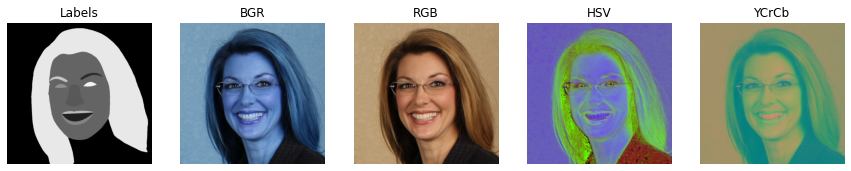

In [172]:
img_BGR = images[example_img]['img']
img_labels = images[example_img]['labels']
plot_diffrent_color_palette(img_BGR,  with_labels = True, labels = img_labels)

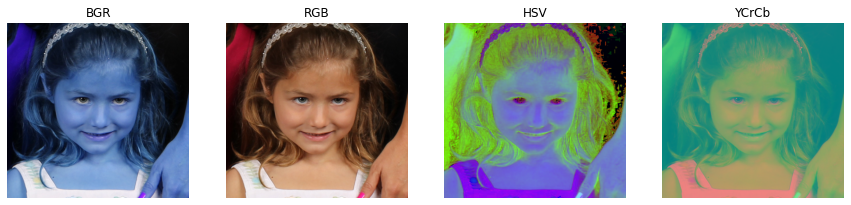

In [174]:
img_BGR = images[list(images.keys())[4]]['img']
plot_diffrent_color_palette(img_BGR)

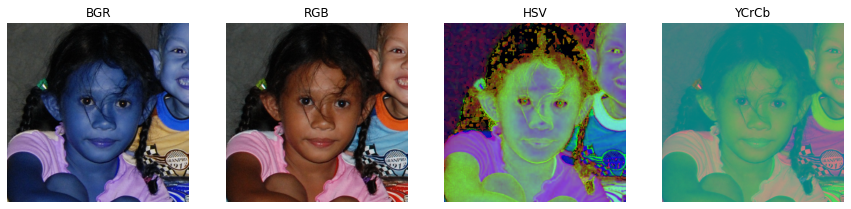

In [175]:
img_BGR = images[list(images.keys())[6]]['img']
plot_diffrent_color_palette(img_BGR)

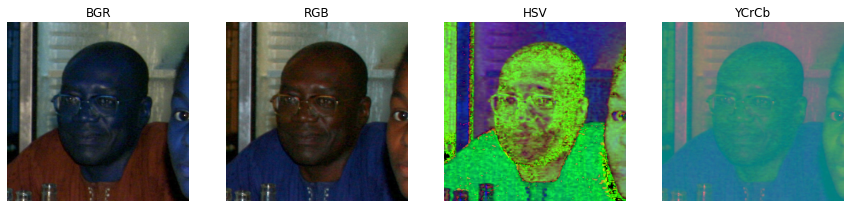

In [176]:
img_BGR = images[list(images.keys())[7]]['img']
plot_diffrent_color_palette(img_BGR)

**Check color palette components**

As we will see later, a very important element in our analysis will be the analysis of the color components of individual pallets.

The component histogram allows us to see the real dependencies and, above all, the color ranges. These range can be "pulled out" by a very simple thresholding.

In [177]:
def plot_color_palette_components(img, title, axes):
    """plot each color component in a separate window and component histogram"""
    for i in range(3):
        component = img[:,:,i]
        plot_img(component, ax = axes[i], title = f'{title}[{i}]')
        plot_hist_with_component(component, axes[-1], f'{title}[{i}]' )
    axes[-1].legend()
    plt.tight_layout()

In [682]:
def plot_diffrent_color_palette_with_components(img_BGR):
    """plot image using a few kind of color palette, each component plot in a separate window"""
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1,5,1)
    plot_img(img_RGB, ax = ax1, title = "RGB")
    
    # definie subplots space for HSV
    axes_hsv = []
    for i in range(4):
        ax = plt.subplot(2,5,i+2)
        axes_hsv.append(ax)

    # plot HSV components
    plot_color_palette_components(img_HSV, 'HSV', axes_hsv)

    # definie subplots space for YCrCb
    axes_YCrCb = []
    for i in range(4):
        ax = plt.subplot(2,5,i+7)
        axes_YCrCb.append(ax)

    # plot YCrCb components
    plot_color_palette_components(img_YCrCb, 'YCrCb', axes_YCrCb)

Now let's compare two pictures of girls, focusing on the color components. In this case, it would be difficult to choose such parameters to be able to designate girls' faces using RGB.

Looking only at the histograms, we can see that we are not able to set such a threshold for the components:  Hsv[2], YCrCb0] to be able to get a good skin extension effect. Moreover, the range of the face skin in the two pictures are different. We can also see that the light have huge influence on result.

The good news is that despite the different shades / ranges, we can clearly see the separation of the skin from the rest of the image, for example on YCrCb[2] is possible (but maybe not perfect). In the first picture, light strands of hair that match the color of the skin may be problematic.

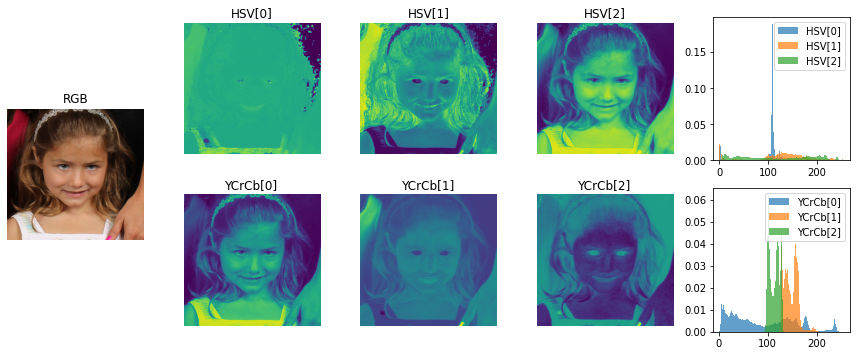

In [179]:
img_BGR = images[list(images.keys())[4]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

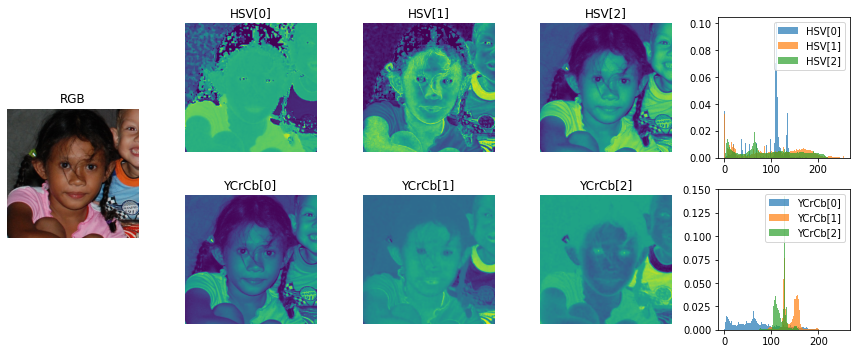

In [180]:
img_BGR = images[list(images.keys())[6]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

Let us consider one more example. The image below has a lot of hype, not good quality, but some very important aspects worth mentioning. Firstly, when analyzing images using classical methods (focusing on e.g. thresholds, colors), it is very difficult to build a general, general algorithm that fits all conditions (image quality, lighting, colors). Second, while one rule might work great for one image, it might not work for another. In the picture below, a very good and clear skin is visible in the combination of HSV[0], HSV[1] and YCrCb[2]. 

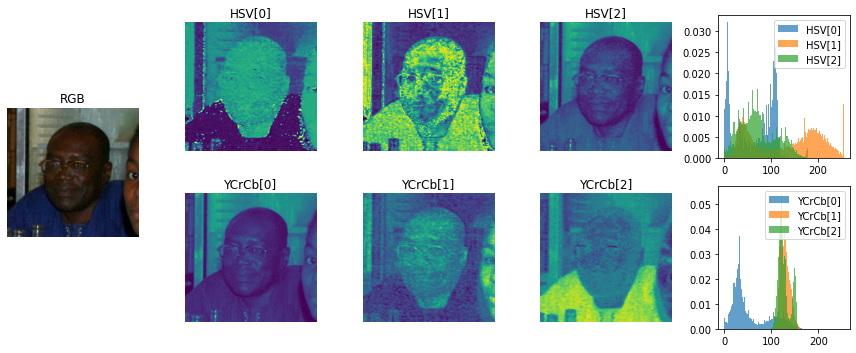

In [181]:
img_BGR = images[list(images.keys())[7]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

**First naive Tresholding**

Let's choose one exemplary component, e.g. YCrCb[2] and try to choose such a range to be able to determine the skin in the image

In [493]:
def plot_treshold_hist(img_RGB, labels_skin_face, component, treshold_range, ax, ax_i, legend, return_mask = False):
    plot_hist_with_component(component, ax[ax_i], legend )
    if type(treshold_range[0]) is int:
        ax[ax_i].axvline(x=treshold_range[0], color = 'r')
        ax[ax_i].axvline(x=treshold_range[1], color = 'b')
    else:
        no_channels = len(treshold_range[0])
        for i in range(no_channels):
            ax[ax_i].axvline(x=treshold_range[0][i], color = 'r')
            ax[ax_i].axvline(x=treshold_range[1][i], color = 'b')
    ax[ax_i].set_title("Histogram with treshold " + legend)
    mask_created_via_treshold = (cv2.inRange(component, * treshold_range)/255).astype(int)
    plot_img(mask_created_via_treshold, ax = ax[ax_i + 1], title = f"binary \n result of using \n treshold {treshold_range}")
    
    plot_img(labels_skin_face*100, ax = ax[ax_i + 2])
    plot_img(mask_created_via_treshold, ax = ax[ax_i + 2],
             alpha = 0.5, 
             title = f"comparison between face skin and \n created mask \n using treshold {treshold_range}")
    
    plot_img(np.dstack([mask_created_via_treshold]*3) * img_RGB, title = f"result \n of using treshold {treshold_range}", ax = ax[ax_i + 3])
    
    if return_mask:
        return mask_created_via_treshold

In [469]:
def simple_tresholding(images, example_img, treshold_ranges):
    
    img_BGR = images[example_img]['img']
    img_labels = images[example_img]['labels']
    labels_skin_face = img_labels==1
    
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    
    
    f, axs = plt.subplots(len(treshold_ranges)+1,4, figsize=(15,15))
    axs = axs.flatten()
    plot_img(img_RGB, ax = axs[0], title = "RGB")
    plot_img(img_labels*100, ax = axs[1], title = "labels")
    component = img_YCrCb[:,:,2]
    plot_img(component, ax = axs[2], title = "YCrCb[2]")
    plot_hist_with_component(component, axs[3])

    j = 4
    for treshold in treshold_ranges:
        plot_treshold_hist(img_RGB, labels_skin_face, component, treshold, axs, j, f'YCrCb[2]')
        j = j + 4

    plt.tight_layout()

Now let's choose some `treshold_ranges`. Of course, they are selected from the first picture I discuss, but it doesn't matter, I just wanted to show you the principle of operation and the problems arising from this method.

In [481]:
# treshold_ranges is list of 3 example range of treshold. At the moment we focus on YCrCb[2]
treshold_ranges = [ [(95), (110)] ,
    [(110), (124)],
    [(124), (int(np.max(component)))]
]

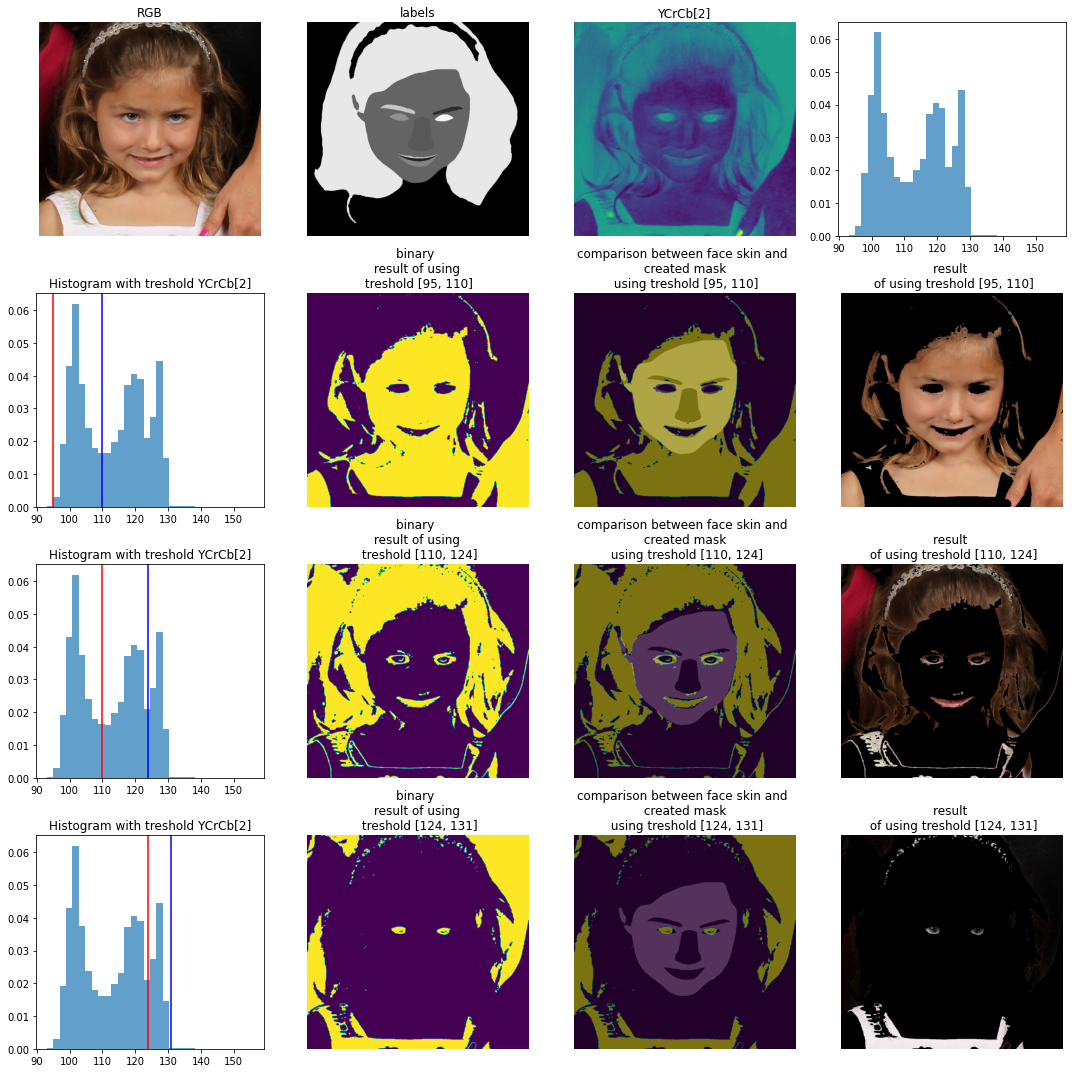

In [482]:
# choose one example image and check how treshold range affects on finall result
example_img = list(images.keys())[4]
simple_tresholding(images, example_img, treshold_ranges)

When we will use exactly the same range and apply to diffrent image effect can be 

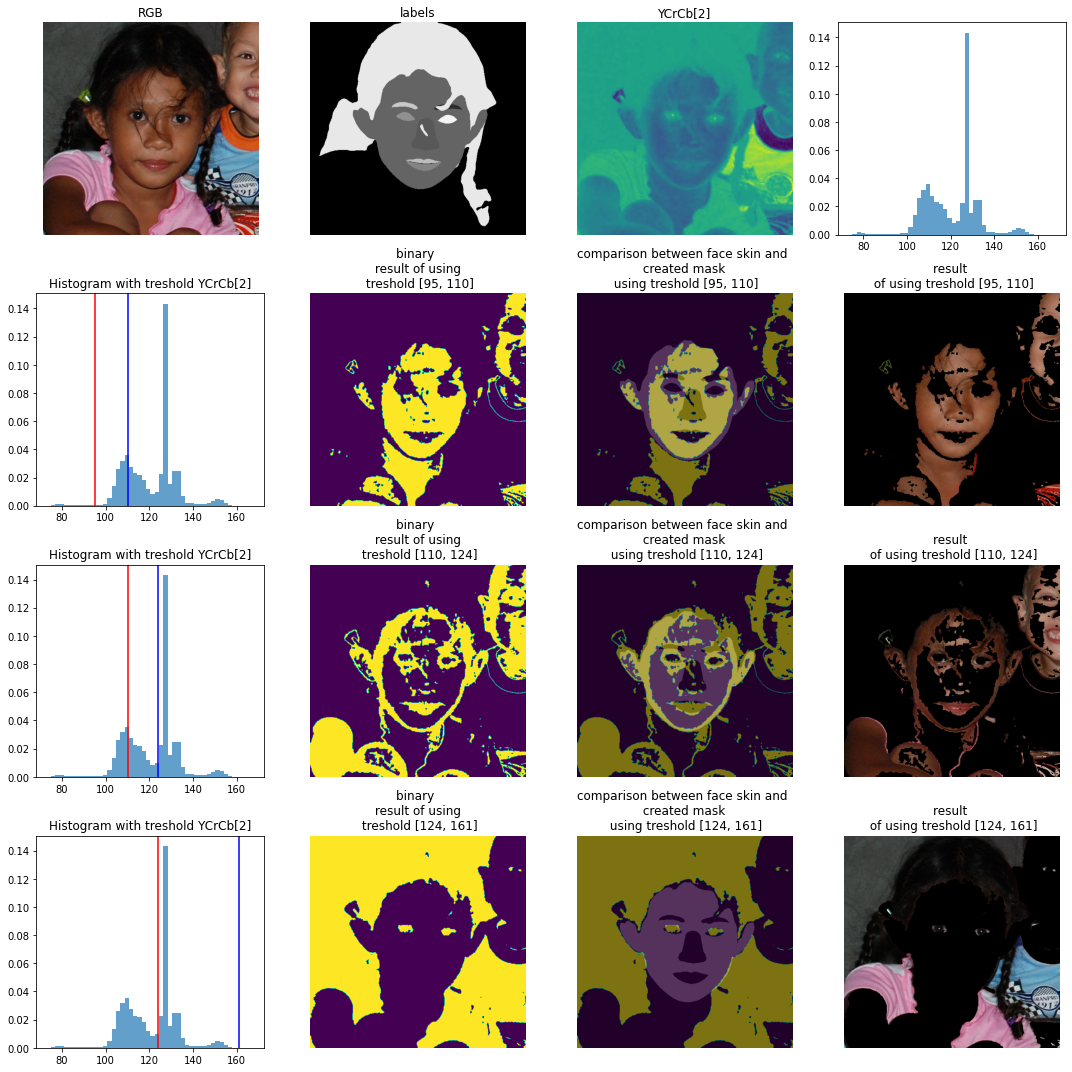

In [154]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[6]
simple_tresholding(images, example_img, treshold_ranges)

Let's check one more image

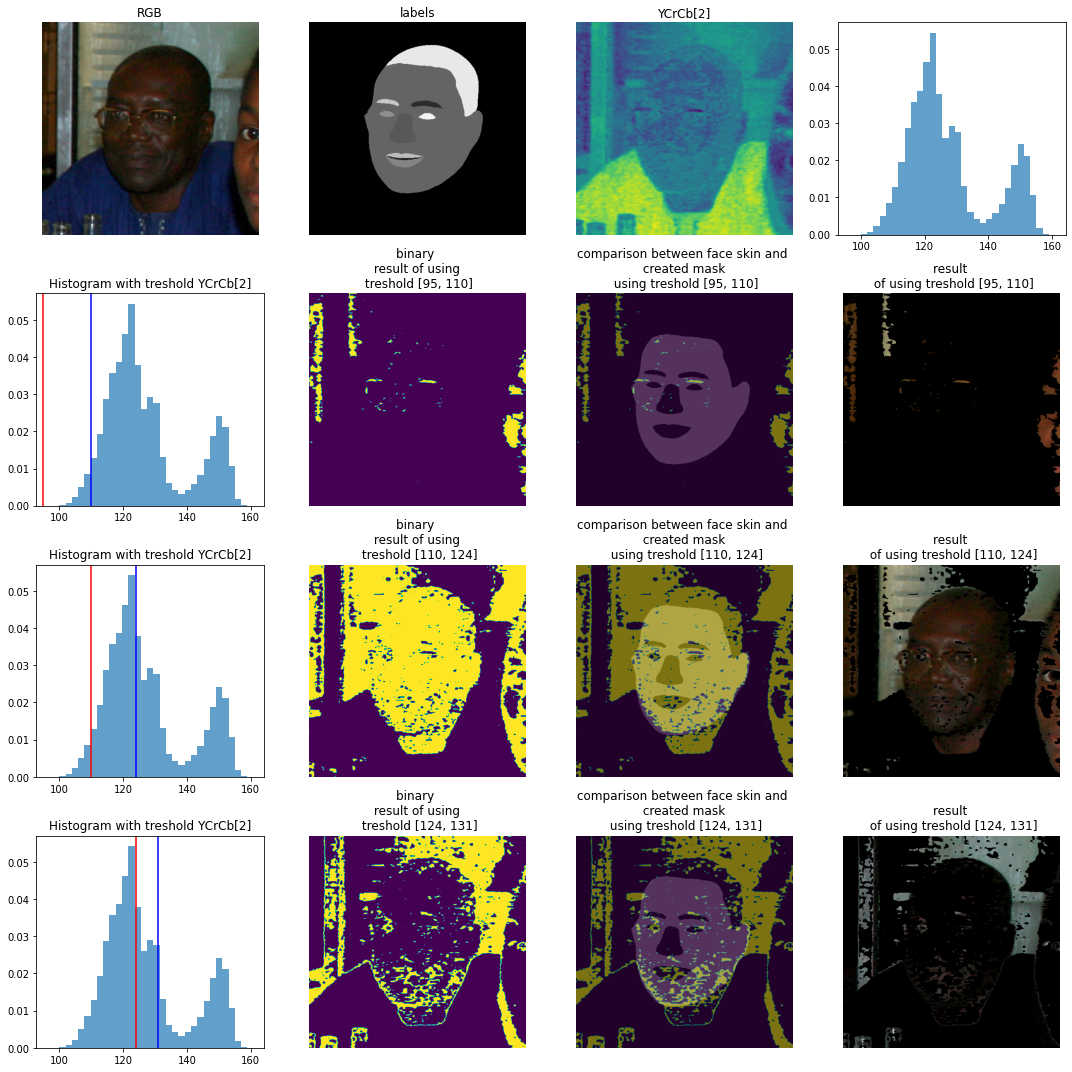

In [483]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[7]
simple_tresholding(images, example_img, treshold_ranges)

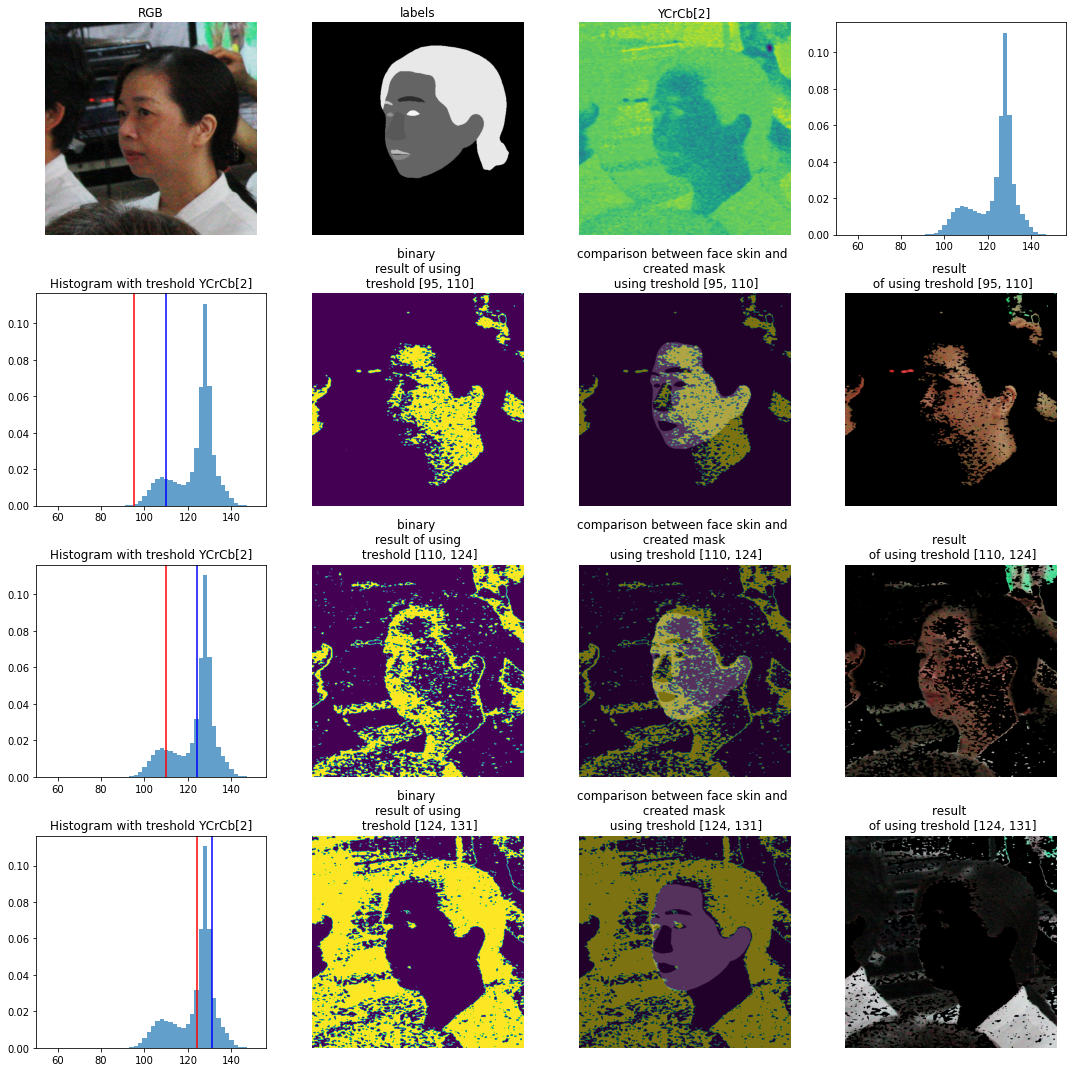

In [484]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[1]
simple_tresholding(images, example_img, treshold_ranges)

several conclusions:
- if we see more than one person in the picture, our database does not have labels for both people.
- matching one threshold is ineffective
- the histogram can have more than> 2 models. The face tends to be at lower values.

we have such a large database, let's check how the mean values ​​for the face are distributed for diffrent color palette.

In [357]:
# Firsly load few examples with labels(!)
images = read_folder(PATH, n = 10, labels = 'labels')

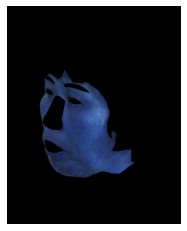

In [358]:
# choose images to example process
example_img = list(images.keys())[3]

# Next, separate a face region that can be interpreted as facial skin (labels = 1)
img = images[example_img]['img']
mask = images[example_img]['labels']
# plot intresing as region
skin_label = (mask==1)
region_img = skin_label * img
plot_img(region_img)

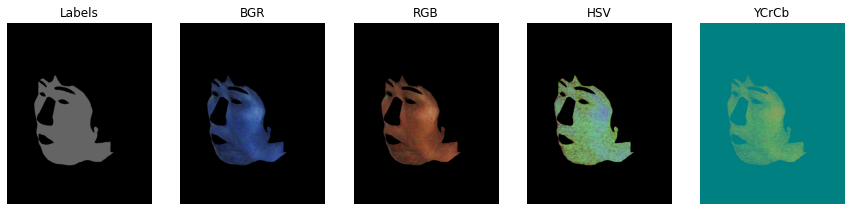

In [359]:
# We can use plot_diffrent_color_palette funtion to show diffrent palette colors
plot_diffrent_color_palette(region_img, True, skin_label)

In [360]:
# calcualte avg of region_img

In [361]:
mask_one_channel = mask[:,:,0] == 1
x = region_img[:,:,0][mask_one_channel].mean()
y = region_img[:,:,1][mask_one_channel].mean()
z = region_img[:,:,2][mask_one_channel].mean()

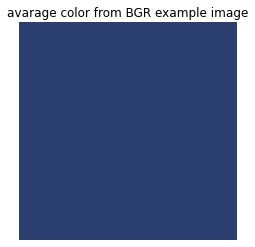

In [362]:
# create image just for new visualization 
avg_img = (x,y,z) * np.ones((2, 2,3))
plt.imshow(avg_img.astype(int))
plt.axis('off')
plt.title('avarage color from BGR example image')
plt.show()

In [363]:
def calculate_img_avg_by_channel(img_palette_color, mask_one_channel):
        x = img_palette_color[:,:,0][mask_one_channel].mean()
        y = img_palette_color[:,:,1][mask_one_channel].mean()
        z = img_palette_color[:,:,2][mask_one_channel].mean()
        return (x,y,z)

In [546]:
def change_img_to_color_palette(img_BGR, RGB = True, HSV = True, YCrCb = True):
    img_RGB, img_HSV, img_YCrCb = None, None, None
    if RGB:
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    if HSV:
        img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2HSV)
    if YCrCb:
        img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    return img_RGB, img_HSV, img_YCrCb

In [365]:
def avg_color(img_BGR, mask_one_channel, plot = True):
    
    img_RGB, img_HSV, img_YCrCb = change_img_to_color_palette(img_BGR)
    
    _title = ['BGR', 'RGB', 'HSV', 'YCrCb']
    
    if plot:
        # definie subplots space
        f, ax = plt.subplots(1,4, figsize=(15,5))
    
    i=0
    _avgs = []
    for img_palette_color in [img_BGR, img_RGB, img_HSV, img_YCrCb]:
        x_y_z = calculate_img_avg_by_channel(img_palette_color, mask_one_channel)
        _avgs.append(x_y_z)
        
        if plot:
            avg_img = (x_y_z * np.ones((2, 2,3))).astype(int)
            plot_img(avg_img, ax = ax[i], title = _title[i])
        i+=1
    return _avgs

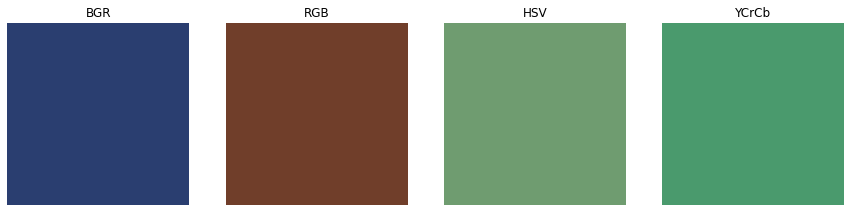

In [366]:
avgs = avg_color(region_img,  mask[:,:,0] == 1)

In [367]:
# Calculate avg using train dataset

In [368]:
# before this part let's download data from https://github.com/lucia123/lapa-dataset! 

In [369]:
# define Path 
PATH = '../LaPa/train'
# load few examples
images_train = read_folder(PATH, n = 1000, labels = 'labels')

In [736]:
def mean_color_definded_by_face_skin_label_in_datasets(images_train, img_key = 'img'):
    images_train_imgs = list(images_train.keys())

    train_avgs = np.zeros((3*4, len(images_train_imgs)))
    i = 0
    for example_img in images_train_imgs:
        img = images_train[example_img][img_key]
        mask = images_train[example_img]['labels']
        mask_one_channel = mask[:,:,0] == 1
        avgs = avg_color(img, mask_one_channel, plot = False)
        train_avgs[:,i] = np.hstack(avgs)
        i += 1

    return train_avgs

In [726]:
train_avgs = mean_color_definded_by_face_skin_label_in_datasets(images_train)

In [371]:
avg_using_train_set = train_avgs.mean(axis=1)

In [729]:
def plot_mean_colors_with_histograms(train_avgs):
    f, ax = plt.subplots(1,4, figsize=(15,5))
    avg_using_train_set = train_avgs.mean(axis=1).reshape(4,3)
    _title = ['BGR', 'RGB', 'HSV', 'YCrCb']

    i = 0
    for x_y_z in avg_using_train_set:
        avg_img = (x_y_z * np.ones((2, 2,3))).astype(int)
        plot_img(avg_img, ax = ax[i], title = _title[i])
        i += 1

    f, ax = plt.subplots(1,4, figsize=(15,3))
    for i in range(0,4): #consider 4 diffrent palette
        for j in range(0,3): #consider 3 channels
            _  = ax[i].hist(train_avgs[j+i*3,:], bins= 80, label = f'{_title[i]}{j}', alpha = 0.7)
        ax[i].legend()

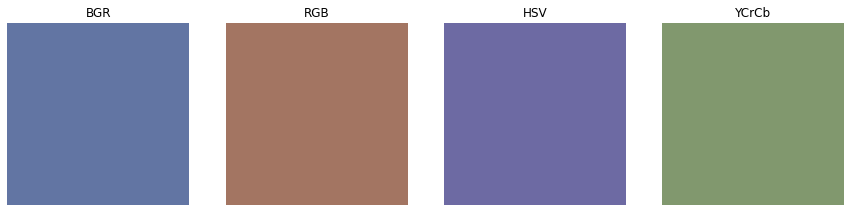

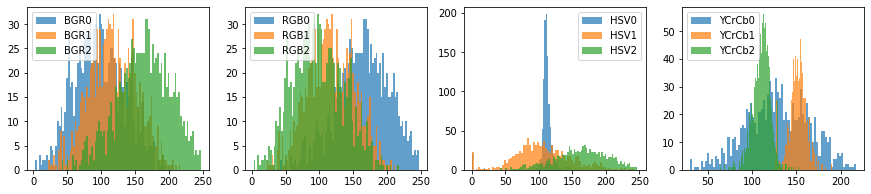

In [730]:
plot_mean_colors_with_histograms(train_avgs)

**Checking the relationship between the HSV and YCrCb components.**  We should not be surprised that there are dependencies betwee components. They result from the way the color palette is encoded on the basis of RGB. I recommend everyone to look at the algorithms for creating the appropriate components.

In [739]:
def check_relationship_HSV_and_YCrCb(_title, train_avgs):
    columns = []
    for i in _title[-2:]:
        for j in range(3):
            columns.append(f'{i}[{j}]')
    df = pd.DataFrame(train_avgs[-6:].T, columns=columns)

    g = sns.PairGrid(df)
    g.map_upper(plot_corr)
    g.map_diag(sns.histplot)
    g.map_lower(sns.regplot)

In [741]:
_title = ['BGR', 'RGB', 'HSV', 'YCrCb']

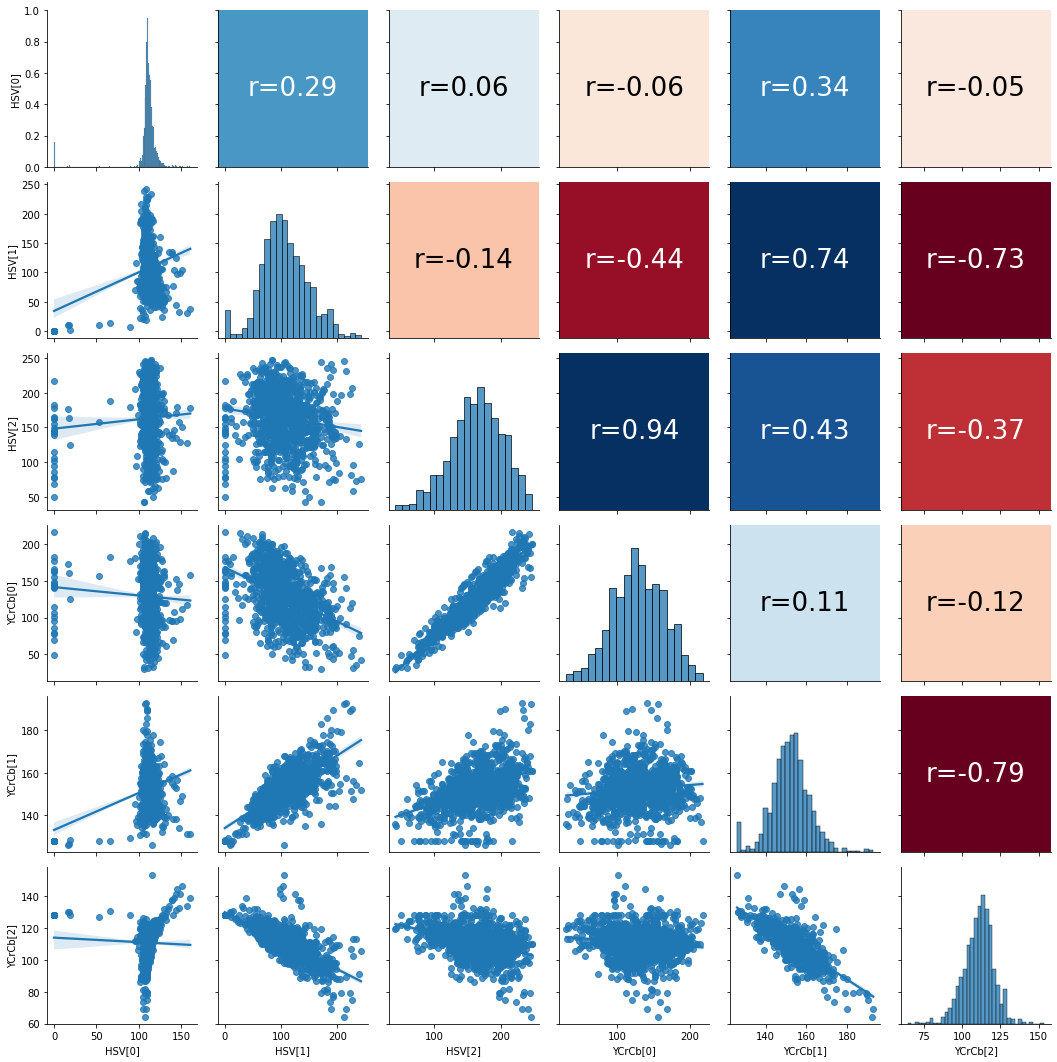

In [742]:
check_relationship_HSV_and_YCrCb(_title, train_avgs)

# Which metrics to choose?

`Precision` - the ratio of the overlap area (detected and wanted areas) to detected area.

`Recall`- the ratio of the overlap area (detected and wanted areas) to wanted area.

`Intersection Over Union (IoU)` - (in statistics it is better known as` Jaccard index`) the ratio of the common overlap area to the total size of the union of the sample sets. This is one of the most popular metrics in image analytics because it can tell us both how much we make a mistake (bigger total area) and how precise we are (overlap area). Note that when we detect spaces other than those we want to detect, in the worst-case scenario, these sets will be separated. Hence the area of union will be maximized and the intersection will be trend to 0.

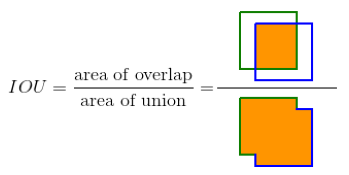

In [105]:
"""
Padilla, Rafael & Netto, Sergio & da Silva, Eduardo. (2020).
A Survey on Performance Metrics for Object-Detection Algorithms. 10.1109/IWSSIP48289.2020. 
"""
iou  = cv2.imread('images_metrics/Intersection-Over-Union-IOU.ppm') 
plot_img(iou)

In [494]:
def check_simple_tresholding_Cb(img_inf, treshold_ranges, return_mask = False):
    img_BGR = img_inf['img']
    img_labels = img_inf['labels']
    labels_skin_face = img_labels==1

    img_RGB, img_HSV, img_YCrCb = change_img_to_color_palette(img_BGR)
    f, axs = plt.subplots(1,6, figsize=(15,3))
    component = img_YCrCb[:,:,2]
    plot_img(img_labels*100, ax = axs[5], title = "labels")
    plot_img(img_RGB, ax = axs[0], title = "RGB")
    generated_mask = plot_treshold_hist(img_RGB, labels_skin_face, component, treshold_ranges[0], axs, 1, 'Cb', return_mask =return_mask)
    plt.tight_layout()
    
    if return_mask:
        return generated_mask

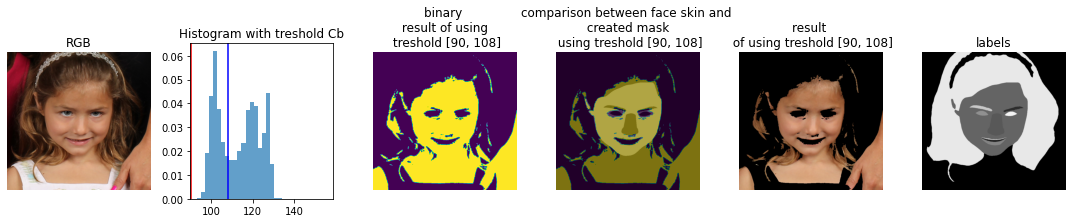

In [496]:
treshold_ranges = [ [(90), (108)] ]
example_img = list(images.keys())[4]
img_inf = images[example_img]
generated_mask = check_simple_tresholding_Cb(img_inf, treshold_ranges, True)

In [756]:
def measure(truth, predicted):
    real = truth.flatten()
    pred = predicted.flatten()
    iou_measure = jaccard_score(real, pred)
    recall_score_measure = recall_score(real, pred, zero_division  = 0)
    precision_score_measure = precision_score(real, pred, zero_division = 0)
    return iou_measure, recall_score_measure, precision_score_measure

In [540]:
truth = (img_inf['labels']==1)[:,:,0]
predicted = generated_mask

In [544]:
iou_measure, recall_score_measure, precision_score_measure = measure(truth, predicted)
print(f'iou: {iou_measure}')
print(f'recall: {recall_score_measure}')
print(f'precision: {precision_score_measure}')

iou: 0.3767724782468579
recall: 0.9548207803992741
precision: 0.38361139846786946


As we can see, we managed to achieve a very naive thresholding of the skin area. The problem, however, is that the skin was not only detected on the face but also on the cleavage and the hand, which does not belong to the girl. 

Despite that we have definded `precision`, `recall` and `IoU`, there is not only one accurate metric to this task. 
- `Recall` will be high value, but `Iou`, `precision` will not. We have to think, if our analysis will be reliable. 
- despite the fact that the values of the metrics are not very reliable, the trend of the metrics (arose as a result of checking hyperparameters ) may give us more information. First of all we would like to maximize the metrics.

**Let's take a closer look at the dataset.**

What if we have more than one person?

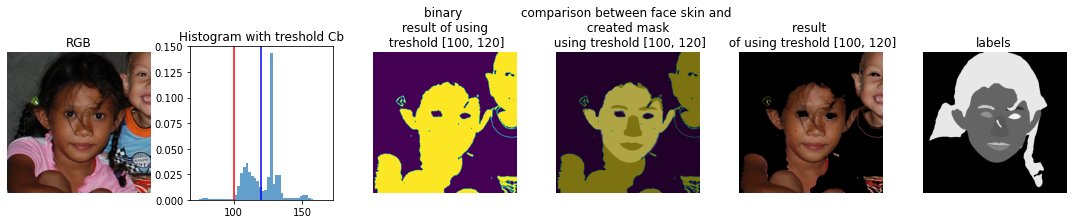

In [326]:
treshold_ranges = [ [(100), (120)] ]
example_img = list(images.keys())[6]
img_inf = images[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

Note that in this case the naive thresholding detected the skin of both characters correctly, including two faces! (The characters had a similar skin tone.). Unfortunately dataset is structured in such a way that we will not get labels referring to the other face. Similar to the previous case `recall` will be high value, but `Iou`, `precision` will not.

What can we do?
- separate region Of Interest (one face), but we are not going do it in this notebook. 

Check yourself! Below there is few cases, you can play with them:

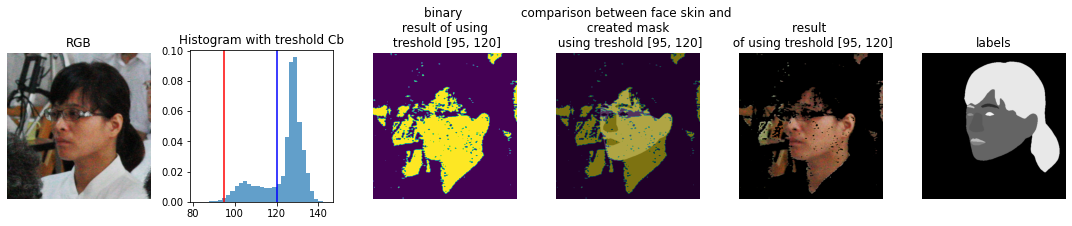

In [333]:
treshold_ranges = [ [(95), (120)] ]
example_img = list(images_train.keys())[6]
img_inf = images_train[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

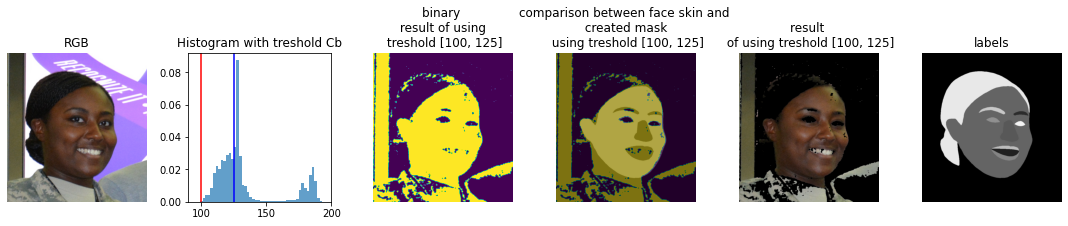

In [334]:
treshold_ranges = [ [(100), (125)] ]
example_img = list(images_train.keys())[120]
img_inf = images_train[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

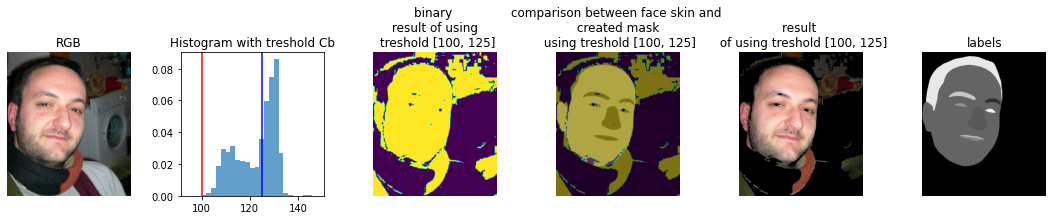

In [335]:
treshold_ranges = [ [(100), (125)] ]
example_img = list(images_train.keys())[150]
img_inf = images_train[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

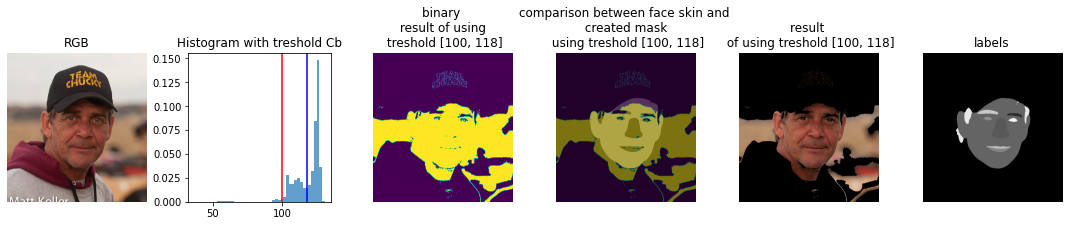

In [331]:
treshold_ranges = [ [(100), (118)] ]
example_img = list(images_train.keys())[500]
img_inf = images_train[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

Limiting the Cb component (from the YCrCb color palette), we can more or less determine the skin colors in the images. Looking at a particular image example, we can say that on average the skin color has variations of about 10, and the average is between 100 and 120. This can also be seen in the image showing the histograms of the corresponding components generated for the substitution of training data.

Of course there is no way that we can set tresholds for all pictures.

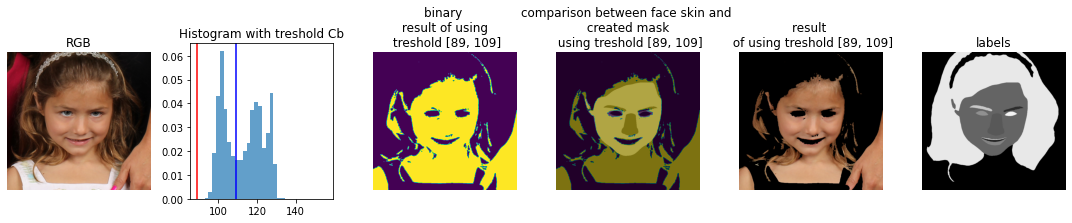

In [345]:
treshold_ranges = [ [(89), (109)] ] #avg = 101, var = 10
example_img = list(images.keys())[4]
img_inf = images[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

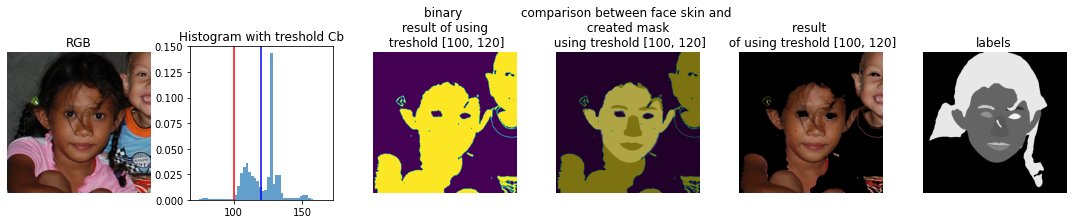

In [338]:
treshold_ranges = [ [(100), (120)] ] #avg = 110, var = 10
example_img = list(images.keys())[6]
img_inf = images[example_img]
check_simple_tresholding_Cb(img_inf, treshold_ranges)

In [458]:
def basic_stats(vector):
    m = np.mean(vector)
    print(f'mean: {m}')
    q1 = np.quantile(vector, 0.05)
    q2 = np.quantile(vector, 0.95)
    print(f'q_{0.05} - quantile 0.05: {q1}')
    print(f'q_{0.95} - quantile 0.95: {q2}')
    print(f'var(vector): {np.var(vector)}')
    print(f'var(q_{0.05} < vector < q_{0.95}): {np.var(vector[(vector>q1) & (vector < q2)])}')
    return m, q1, q2

In [459]:
Cb = train_avgs[-1]

In [460]:
m, q1, q2 = basic_stats(Cb)

mean: 110.84156467802383
q_0.05 - quantile 0.05: 94.10386877473081
q_0.95 - quantile 0.95: 126.79049529982204
var(vector): 103.32580999623993
var(q_0.05 < vector < q_0.95): 54.746700073652285


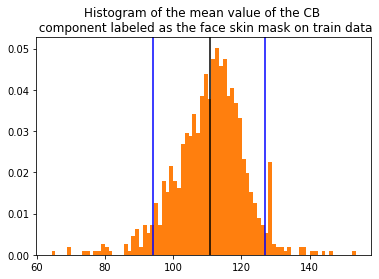

In [464]:
# plot histogram of the mean value of the CB component labeled as the face skin mask on train data
_  = plt.hist(Cb, bins= 80, color = 'tab:orange', density = True)
plt.title('Histogram of the mean value of the CB \n component labeled as the face skin mask on train data')
# plot vertical line = q_0.05
plt.axvline(x=q1, color = 'b')
# plot vertical line = q_0.95
plt.axvline(x=q2, color = 'b')
# plot black vertical line = mean(avg Cb component)
plt.axvline(x=m, color = 'k')
plt.show()

In [751]:
def calculate_metrics_grid_search(grid_tresholds, images, example_img, img_key = 'img'):
    img_inf = images[example_img]
    img_BGR = img_inf[img_key]
    img_labels = img_inf['labels']
    labels_skin_face = (img_labels==1)[:,:,0]

    _, _, img_YCrCb = change_img_to_color_palette(img_BGR, False, False, True)
    component = img_YCrCb[:,:,2]
    iou_measure_list, recall_score_measure_list, precision_score_measure_list = [], [], []
    example_img_list = []
    treshold_range_list = []
    
    for treshold_range in grid_tresholds:
        mask_created_via_treshold = (cv2.inRange(component, *treshold_range)/255).astype(int)
        iou_measure, recall_score_measure, precision_score_measure = measure(labels_skin_face, mask_created_via_treshold)
        
        iou_measure_list.append(iou_measure)
        recall_score_measure_list.append(recall_score_measure)
        precision_score_measure_list.append(precision_score_measure)
        example_img_list.append(example_img)
        treshold_range_list.append(treshold_range)
    
    return {'iou' : iou_measure_list,
            'recall_scores' : recall_score_measure_list, 
            'precision_scores' : precision_score_measure_list ,
            'example_imgs' : example_img_list,
            'treshold_ranges': treshold_range_list}

In [596]:
grid_tresholds = []
setted_var = 10

for i in range(90,135,5):
    grid_tresholds.append([i - setted_var, i + setted_var])

In [757]:
def calc_measures(grid_tresholds, images, img_key = 'img'):
    iou_measure_list, recall_score_measure_list, precision_score_measure_list = [], [], []
    example_img_list = []
    treshold_range_list = []

    for example_img in  images.keys():
        measures  = calculate_metrics_grid_search(grid_tresholds, images, example_img, img_key)
        iou_measure_list = iou_measure_list + measures['iou']
        recall_score_measure_list = recall_score_measure_list + measures['recall_scores']
        precision_score_measure_list = precision_score_measure_list + measures['precision_scores']
        example_img_list = example_img_list + measures['example_imgs']
        treshold_range_list = treshold_range_list +  measures['treshold_ranges']

    d = {'iou': iou_measure_list,
         'recall': recall_score_measure_list,
         'precision': precision_score_measure_list,
         'img_name': example_img_list,
         'treshold': treshold_range_list}
    df = pd.DataFrame(data=d)
    df['treshold_mean'] = [int(np.mean(i)) for i in df['treshold']]
    return df

In [758]:
df = calc_measures(grid_tresholds, images_train)

In [759]:
df.head()

iou    recall  precision       img_name    treshold  treshold_mean
0  0.442344  0.616548   0.610221  10001436895_0   [80, 100]             90
1  0.328695  0.744861   0.370398  10001436895_0   [85, 105]             95
2  0.282491  0.849494   0.297374  10001436895_0   [90, 110]            100
3  0.257606  0.813019   0.273829  10001436895_0   [95, 115]            105
4  0.113760  0.414408   0.135550  10001436895_0  [100, 120]            110

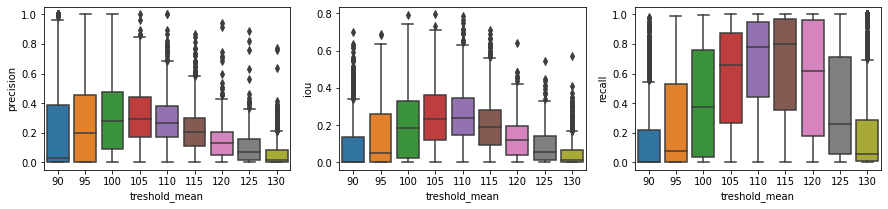

In [760]:
fig, ax = plt.subplots(1,3, figsize = (15,3))
_ = sns.boxplot(x="treshold_mean", y="precision", data=df, ax = ax[0])
_ = sns.boxplot(x="treshold_mean", y="iou", data=df, ax = ax[1])
_ = sns.boxplot(x="treshold_mean", y="recall", data=df, ax = ax[2])


In [761]:
def equalizeHists(img):

    channels = cv2.split(img)
    output = []

    for i in channels:
        output.append(cv2.equalizeHist(i))

    equ = cv2.merge(output)
    
    return equ

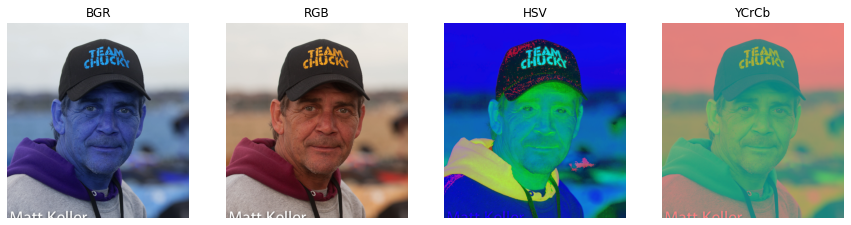

In [720]:
plot_diffrent_color_palette(img_BGR)

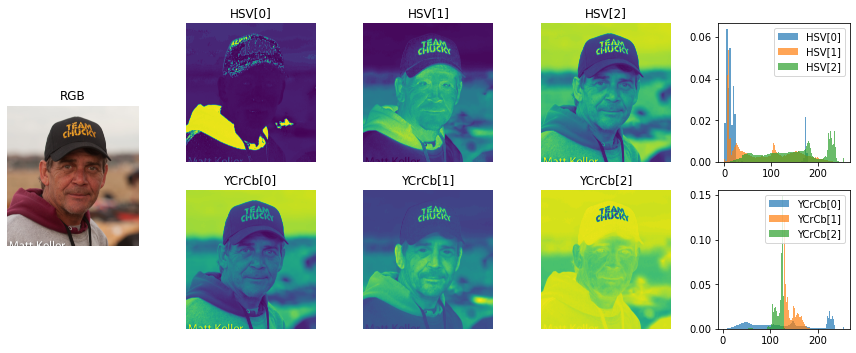

In [723]:
plot_diffrent_color_palette_with_components(img_BGR)

In [721]:
equ = equalizeHists(img_BGR)

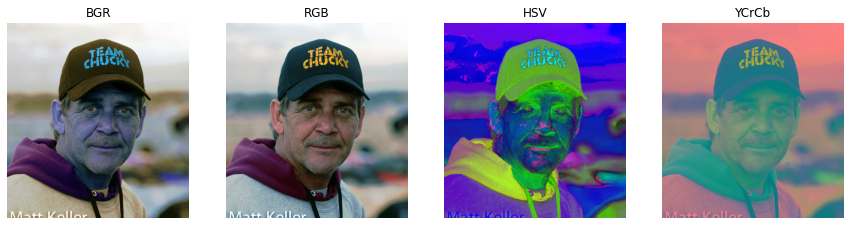

In [722]:
plot_diffrent_color_palette(equ)

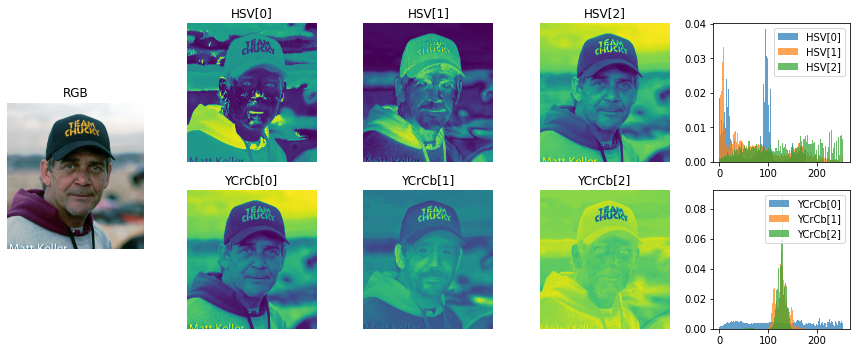

In [724]:
plot_diffrent_color_palette_with_components(equ)

In [734]:
for img_key in images_train:
    img_BGR = images_train[img_key]['img']
    equ = equalizeHists(img_BGR)
    images_train[img_key]['img_equ']  = equ

In [737]:
train_avgs_using_equalizeHists = mean_color_definded_by_face_skin_label_in_datasets(images_train, 'img_equ')

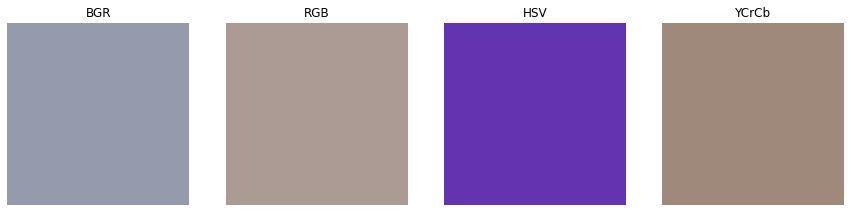

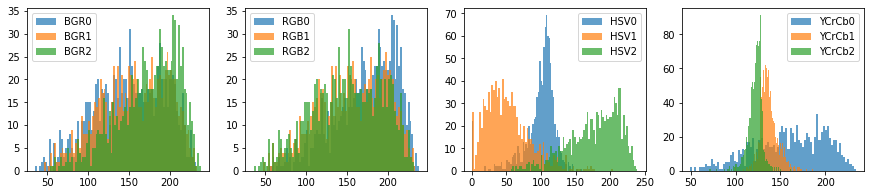

In [738]:
plot_mean_colors_with_histograms(train_avgs_using_equalizeHists)

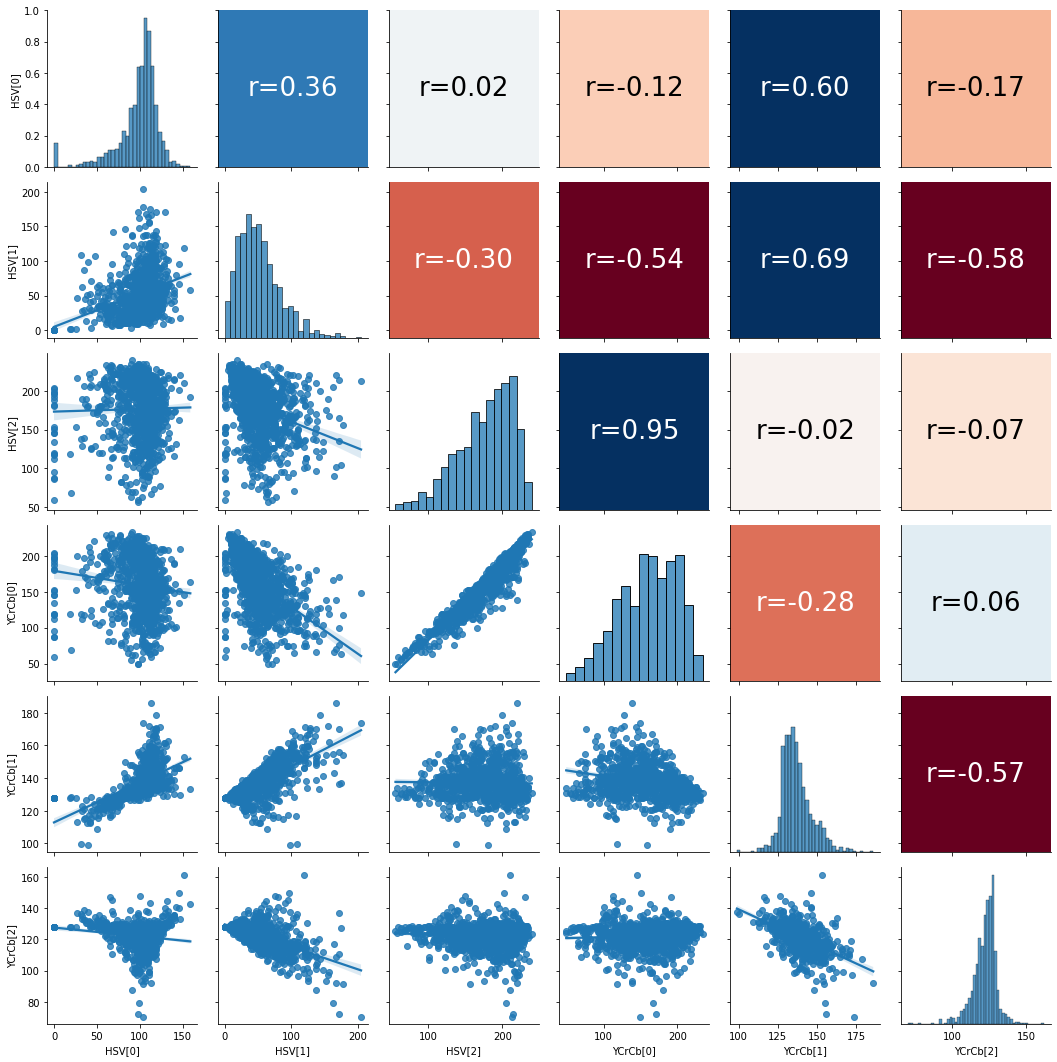

In [743]:
check_relationship_HSV_and_YCrCb(_title, train_avgs_using_equalizeHists)

In [744]:
Cb_using_equalizeHists = train_avgs_using_equalizeHists[-1]

In [745]:
m, q1, q2 = basic_stats(Cb_using_equalizeHists)

mean: 122.15744231791943
q_0.05 - quantile 0.05: 108.43706518800188
q_0.95 - quantile 0.95: 132.07062864042408
var(vector): 65.942863177113
var(q_0.05 < vector < q_0.95): 28.52446152043428


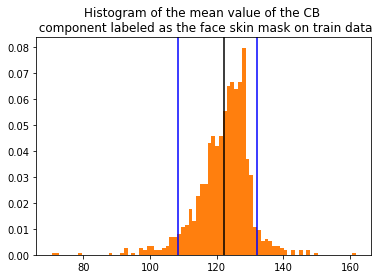

In [746]:
# plot histogram of the mean value of the CB component labeled as the face skin mask on train data
_  = plt.hist(Cb_using_equalizeHists, bins= 80, color = 'tab:orange', density = True)
plt.title('Histogram of the mean value of the CB \n component labeled as the face skin mask on train data')
# plot vertical line = q_0.05
plt.axvline(x=q1, color = 'b')
# plot vertical line = q_0.95
plt.axvline(x=q2, color = 'b')
# plot black vertical line = mean(avg Cb component)
plt.axvline(x=m, color = 'k')
plt.show()

In [764]:
grid_tresholds = []
setted_var = 10

for i in range(100,140,5):
    grid_tresholds.append([i - setted_var, i + setted_var])

In [765]:
df_equ = calc_measures(grid_tresholds, images_train, 'img_equ')

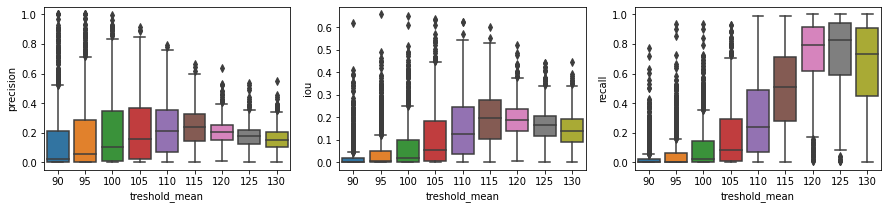

In [763]:
fig, ax = plt.subplots(1,3, figsize = (15,3))
_ = sns.boxplot(x="treshold_mean", y="precision", data=df_equ, ax = ax[0])
_ = sns.boxplot(x="treshold_mean", y="iou", data=df_equ, ax = ax[1])
_ = sns.boxplot(x="treshold_mean", y="recall", data=df_equ, ax = ax[2])


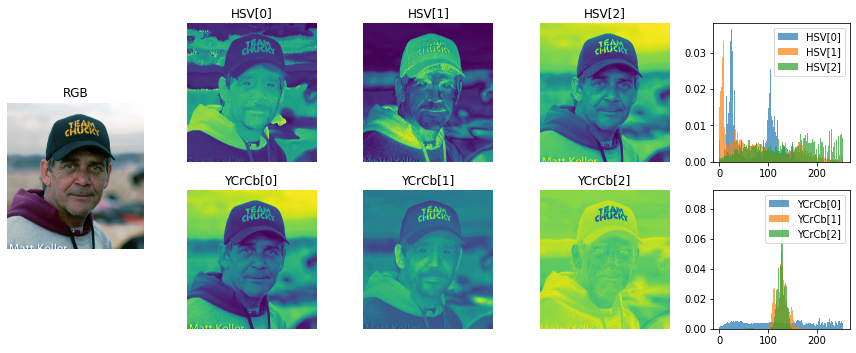

In [673]:
plot_diffrent_color_palette_with_components(equ)

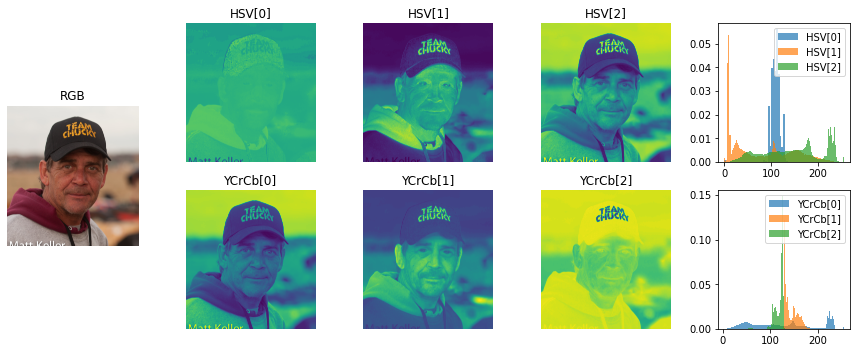

In [314]:
plot_diffrent_color_palette_with_components(img_BGR)

Limiting the Cb component (from the YCrCb color palette), we can more or less determine the skin colors in the images. Looking at a particular image example, we can say that on average the skin color has variations of about 10, and the average is between 100 and 120. This can also be seen in the image showing the histograms of the corresponding components generated for the substitution of training data.